In [ ]:
!pip install transformers
!pip install datasets

In [5]:
from tqdm.notebook import tqdm
from collections import defaultdict

# import numpy as np
# import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from datasets import load_dataset

from transformers import BertTokenizer, BertConfig, DataCollatorWithPadding
from transformers import AdamW, BertModel, BertForSequenceClassification

from IPython.display import clear_output
%matplotlib inline

from pprint import pprint

sns.set(font_scale=1.2)
sns.set_style(style='whitegrid')
device_num = 0

In [6]:
import sklearn.metrics
from sklearn.model_selection import KFold
from sklearn.metrics import (
    confusion_matrix, mean_squared_error, roc_auc_score
)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

from catboost import CatBoostRegressor, Pool, CatBoostClassifier

from transformers import (
    AutoTokenizer,
    AutoModel,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    AutoModelForSequenceClassification
)

In [7]:
device = "mps" if torch.backends.mps.is_available() else f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vk-spam-dataset/test_spam.csv
/kaggle/input/vk-spam-dataset/train_spam.csv


Загрузим данные

In [9]:
train = pd.read_csv('/kaggle/input/vk-spam-dataset/train_spam.csv')
test = pd.read_csv('/kaggle/input/vk-spam-dataset/test_spam.csv')

train.head(3)

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...


In [10]:
test.head(3)

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...


## Первичный анализ

In [11]:
len(train), len(test)

(16278, 4070)

Посмотрим на долю спама в данных вообще

In [12]:
train['label'] = 1
train.loc[train['text_type'] == 'ham', 'label'] = 0

train['label'].mean()

0.2954294139329156

Добавим числовые фичи

In [13]:
train['seq_len'] = train['text'].apply(lambda x: len(x))
train['word_num'] = train['text'].apply(lambda x: len(x.split()))
train['mean_word_len'] = train['text'].apply(lambda x: len(x) / len(x.split()))

test['seq_len'] = test['text'].apply(lambda x: len(x))
test['word_num'] = test['text'].apply(lambda x: len(x.split()))
test['mean_word_len'] = test['text'].apply(lambda x: len(x) / len(x.split()))

train.head(3)

,text_type,text,label,seq_len,word_num,mean_word_len
0,ham,make sure alex knows his birthday is over in f...,0,86,16,5.375000
1,ham,a resume for john lavorato thanks vince i will...,0,520,97,5.360825
2,spam,plzz visit my website moviesgodml to get all m...,1,126,22,5.727273


Посмотрим на среднюю символьную длину сообщения и количество слов в зависимости от класса

In [14]:
train[train['label'] == 1]['seq_len'].mean(), train[train['label'] == 0]['seq_len'].mean()

(301.35724682886257, 314.168279710524)

In [15]:
train[train['label'] == 1]['mean_word_len'].mean(), train[train['label'] == 0]['mean_word_len'].mean()

(5.715075781660779, 5.22812504511605)

Видим, что у обычных сообщений в среднем меньше слов, но больше символов.  

Визуализируем распределения

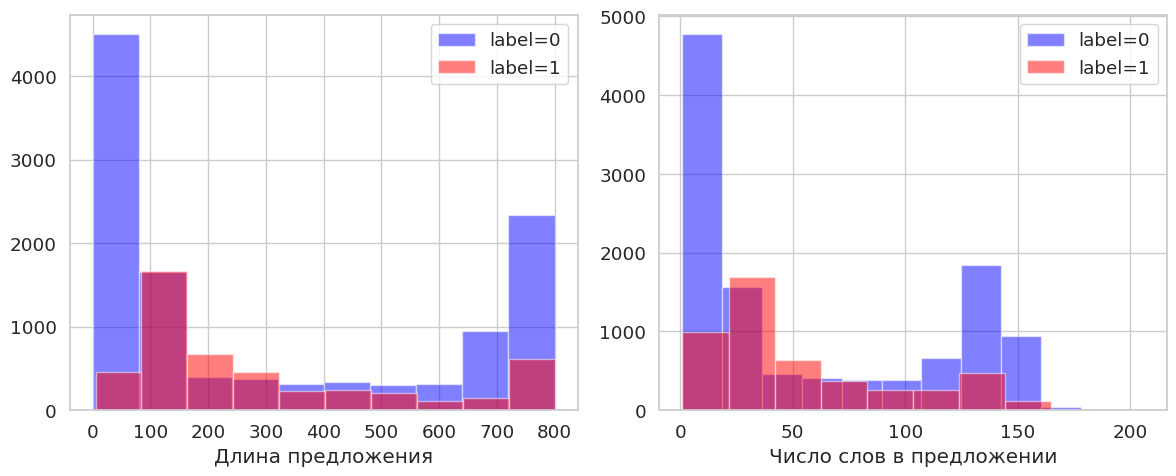

In [16]:
# Разделяем данные на две группы по метке label
label_0 = train[train['label'] == 0]
label_1 = train[train['label'] == 1]

# Создаем 2 графика
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(label_0['seq_len'], color='blue', alpha=0.5, label='label=0')
plt.hist(label_1['seq_len'], color='red', alpha=0.5, label='label=1')
plt.xlabel('Длина предложения')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(label_0['word_num'], color='blue', alpha=0.5, label='label=0')
plt.hist(label_1['word_num'], color='red', alpha=0.5, label='label=1')
plt.xlabel('Число слов в предложении')
plt.legend()

plt.tight_layout()
plt.show()

Среди обычных сообщений преобладают либо короткие до 40 слов, либо длинные от 120 слов. В спаме же больше всего сообщений в районе 100-200 символов, до 50 слов в предложении.  

---

### Подготовим данные

Разобьём тренировочные данные на `train`, `valid`. Выделим отдельно текст, фичи и лейбл

In [17]:
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=42)

train_texts = train_df['text']
train_features = train_df[['seq_len', 'mean_word_len', 'word_num']]
train_label = train_df['label']

valid_texts = valid_df['text']
valid_features = valid_df[['seq_len', 'mean_word_len', 'word_num']]
valid_label = valid_df['label']

test_texts = test['text']
test_features = test[['seq_len', 'mean_word_len', 'word_num']]
# test_label = test_df['label']

### Модель 1  

Сначала попробуем просто обучить `catboost` на извлечённых фичах.

In [19]:
train_pool = Pool(
    train_features, label=train_label,
    feature_names=list(train_features.columns)
)
valid_pool = Pool(
    valid_features, label=valid_label,
    feature_names=list(valid_features.columns)
)
test_pool = Pool(
    test_features,
    feature_names=list(test_features.columns)
)

In [21]:
model_cat = CatBoostClassifier(
    n_estimators=10000,
    eval_metric='AUC',
    use_best_model=True, 
    random_state=42
)
model_cat.fit(
    train_pool, eval_set=valid_pool, metric_period=1000,
)
y_pred_cat = model_cat.predict(test_pool)

Learning rate set to 0.02194
0:	test: 0.7838305	best: 0.7838305 (0)	total: 4.52ms	remaining: 45.2s
1000:	test: 0.8196297	best: 0.8196297 (1000)	total: 4.18s	remaining: 37.6s
2000:	test: 0.8157677	best: 0.8196297 (1000)	total: 8.1s	remaining: 32.4s
3000:	test: 0.8117781	best: 0.8196297 (1000)	total: 12s	remaining: 28.1s
4000:	test: 0.8080695	best: 0.8196297 (1000)	total: 16s	remaining: 24s
5000:	test: 0.8041864	best: 0.8196297 (1000)	total: 19.9s	remaining: 19.9s
6000:	test: 0.8009663	best: 0.8196297 (1000)	total: 23.9s	remaining: 15.9s
7000:	test: 0.7980683	best: 0.8196297 (1000)	total: 27.9s	remaining: 11.9s
8000:	test: 0.7955201	best: 0.8196297 (1000)	total: 31.8s	remaining: 7.95s
9000:	test: 0.7933027	best: 0.8196297 (1000)	total: 35.9s	remaining: 3.98s
9999:	test: 0.7910181	best: 0.8196297 (1000)	total: 40.2s	remaining: 0us

bestTest = 0.8196296544
bestIteration = 1000

Shrink model to first 1001 iterations.


Если считать модель, которое всё идентифицирует как не-спам бэйзлайном, то её `roc-auc`

In [41]:
true_labels = np.array(valid_df['label'])
baseline_preds = np.ones(len(true_labels))

roc_auc_score(true_labels, baseline_preds)

0.5

Кэтбуст показал хорошие результаты относительно бэйзлайна, `bestTest = 0.8196` на валидации.  

---

### Модель 2

Теперь попробуем обучить модель типа `BERT` на текстовых данных.

In [23]:
from sklearn.metrics import roc_auc_score
from scipy.special import expit

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    threshold = 0.6
    probs = expit(logits)
    predictions = np.zeros(probs.shape)
    predictions[np.where(probs >= threshold)] = 1

    return {"roc_auc": roc_auc_score(labels, predictions)}

In [24]:
from transformers import BertTokenizer, BertForSequenceClassification

In [65]:
# Параметры эксперимента
# device = torch.device("cuda")
n_gpu = 1
batch_size = 8
num_epochs = 3
max_seq_length = 512
learning_rate = 2e-5

In [26]:
# Загрузка предварительно обученной модели и токенизатора
# Зададим модель и токенайзер
model_name_or_path = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
data_collator = DataCollatorWithPadding(tokenizer)

model_bert = BertForSequenceClassification.from_pretrained(model_name_or_path, num_labels=2)
model_bert.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Создадим датасеты из данных, которые можно будеть подать в трейнер

In [27]:
from datasets import Dataset

In [60]:
def add_special_tokens(example):
    example["text"] = "[CLS] " + example["text"] + " [SEP]"
    return example

def train_valid_to_dataset(train, valid):
    # Подготовка данных для обучения и валидации
    train_dataset = Dataset.from_dict({
        "text": train['text'],          # тексты
        "labels": train['label']      # метки
    })

    valid_dataset = Dataset.from_dict({
        "text": valid['text'],
        "labels": valid['label']
    })
    
    train_dataset = train_dataset.map(add_special_tokens)
    valid_dataset = valid_dataset.map(add_special_tokens)

    train_dataset = train_dataset.map(# применяем функцию к каждому элементу датасета
        lambda elem: tokenizer(
            elem["text"],             #  токенизируем поле text
            add_special_tokens=True,  #  автоматически добавляем CLS, SEP токены
            truncation=True,          #  обрезаем ли последовательность
            max_length=256,           #  ограничение на длину,
            #return_tensors="pt"
        )
    )

    valid_dataset = valid_dataset.map(
        lambda elem: tokenizer(
            elem["text"],
            add_special_tokens=True,
            truncation=True,
            max_length=256,
            #return_tensors="pt"
        )
    )

    train_dataset = train_dataset.remove_columns("text")
    valid_dataset = valid_dataset.remove_columns("text")

    return train_dataset, valid_dataset

In [61]:
train_dataset, valid_dataset = train_valid_to_dataset(train_df, valid_df)

Map:   0%|          | 0/13022 [00:00<?, ? examples/s]

Map:   0%|          | 0/3256 [00:00<?, ? examples/s]

Map:   0%|          | 0/13022 [00:00<?, ? examples/s]

Map:   0%|          | 0/3256 [00:00<?, ? examples/s]

In [70]:
# аргументы для обучения
args = TrainingArguments(
    f"./results",                               # директория, куда можно будет сохранить чекпоинты, логи
    evaluation_strategy="no",                # прогоняем валидацию каждую эпоху
    save_strategy="no",                      # сохраняем чекпоинт после каждой эпохи
    save_steps=2000,
    learning_rate=3e-4,                         # learning rate обучения
    per_device_train_batch_size=batch_size,     # размер батча для обучения
    per_device_eval_batch_size=batch_size,      # размер батча для валидации
    num_train_epochs=num_epochs,                # количество эпох для обучения
    weight_decay=0.01,                          # параметр регуляризации
    # metric_for_best_model="roc_auc",
    # load_best_model_at_end=True,                # загрузить в конце лучший чекпоинт по валидации,
    report_to="none",                           # не используем более продвинутые способы кодирования
    label_names=['labels'] 
)

In [71]:
model_bert_trainer = Trainer(
    model_bert,                              # модель
    args,                               # аргменты обучения
    train_dataset=train_dataset,        # обучающий датасет
    eval_dataset=valid_dataset,           # валидационный датасет
    data_collator=data_collator,        # data collator
    tokenizer=tokenizer,                # токенизатор, используется в data collator
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [73]:
model_bert_trainer.train()

custom_model_name = "model_bert"
model_bert.save_pretrained(custom_model_name)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.608200
1000,0.609800
1500,0.607200
2000,0.606000


In [ ]:
vk_bert_model = BertForSequenceClassification.from_pretrained("vk_bert_model", num_labels=2)
model_bert.to(device)

In [74]:
valid_loader = DataLoader(valid_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         collate_fn=data_collator)

In [75]:
model_bert.eval()
test_preds, test_labels = [], []

for batch in tqdm(valid_loader, desc="testing"):
    with torch.no_grad():
        model_output = model_bert(
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device)
        )
        logits = model_output.logits

    y_pred = logits.max(1)[1].detach().cpu().numpy()
    test_preds.extend(y_pred)
    test_labels.extend(batch["labels"].numpy())

testing:   0%|          | 0/407 [00:00<?, ?it/s]

In [76]:
roc_auc_score(test_labels, test_preds)

0.5

Модель не смогла уловить какие-либо зависимости и даёт такой же результат, как рандомная модель или предсказание единицы во всех случаях.

Исходя из предыдущего, выберем в качестве основной модели кэтбуст

In [86]:
test_res = pd.DataFrame(test['text'])
test_res['score'] = y_pred_cat
test_res
test_res.to_csv('/kaggle/working/score_model_res')